In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std
import astropy.units as u
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [21]:
DARK_IMAGETYP='dark'
BIAS_IMAGETYP='bias'
FLAT_IMAGETYP='flat'

def find_nearest_dark_exposure(
        science_frame : CCDData,
        dark_exposure_times,
        tolerance=0.5
    ) -> float:
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - science_frame.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(science_frame.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, science_frame.header['exptime']))
        
    
    return closest_dark_exposure

def select_dark_frame(
        science_frame : CCDData,
        dark_frames : ccdp.ImageFileCollection
    ) -> CCDData:
    """
    """
    keyed_frames = {ccd.header['exposure']: ccd for ccd in dark_frames.ccds(imagetyp=DARK_IMAGETYP, combined=True)}
    closest_dark = find_nearest_dark_exposure(science_frame=science_frame, dark_exposure_times=keyed_frames.keys(), tolerance=None)

    return keyed_frames[closest_dark]

def select_flat_frame(
        science_frame : CCDData,
        flat_frames : ccdp.ImageFileCollection
    ) -> CCDData:
    """
    """
    combined_flats = {ccd.header['filter']: ccd for ccd in flat_frames.ccds(imagetyp=FLAT_IMAGETYP, combined=True)}
    flat_frame = combined_flats.get(science_frame.header['filter'], None)
    
    return flat_frame

def subtract_bias(
        frames : ccdp.ImageFileCollection,
        master_bias : CCDData,
        output_path : Path
    ) -> ccdp.ImageFileCollection:
    """
    Subtract bias from one of more frames

    Parameters
    ----------
    frames : ccdproc.ImageFileCollection
        Frames from which to subtract bias
    combined_bias : astropy.nddata.CCDData
        Combined/Calibrated bias data
    output_path : pathlib.Path
        Output directory to save CCD data
    

    Returns
    -------
    ccdproc.ImageFileCollection
        Calibrated frames

    """
    if(output_path is not None):
        output_path.mkdir(exist_ok=True)
    
    for ccd, file_name in frames.ccds(return_fname=True, save_location=output_path, unit='adu'):
        ccd = ccdp.subtract_bias(ccd, master_bias, unit='adu')
        ccd.write()
        
    return frames

def subtract_dark(
        frames : ccdp.ImageFileCollection,
        master_dark : CCDData,
        output_path: Path
    ) -> ccdp.ImageFileCollection:
    """
    Subtract dark from one of more frames

    Parameters
    ----------
    frames : ccdproc.ImageFileCollection
        Frames from which to subtract dark
    combined_bias : astropy.nddata.CCDData
        Combined/Calibrated bias data
    output_path : pathlib.Path
        Output directory to save CCD data
    

    Returns
    -------
    ccdproc.ImageFileCollection
        Calibrated frames

    """
    if(output_path is not None):
        output_path.mkdir(exist_ok=True)
    
    for ccd, file_name in frames.ccds(return_fname=True, save_location=output_path, ccd_kwargs={'unit': 'adu'}):
        ccd = ccdp.subtract_dark(ccd, master_dark, exposure_time='exptime', exposure_unit=u.second, scale=True)
        ccd.write()
    
    return frames
        
def calibrate_bias(
        science_frame : CCDData,
        bias_path : Path
    ) -> CCDData:
    """
    Calibrate and combine bias frames to create a master bias frame

    Parameters
    ----------
    science_frame : astropy.nddata.CCDData
        Science frame
    bias_path : pathlib.Path
        directory to search for bias frames

    Returns
    -------
    astropy.nddata.CCDData
        Calibrated master bias frame

    """
    fits_files = ccdp.ImageFileCollection(location=bias_path, find_fits_by_reading=False, glob_include='*.fits')
    bias_frames = fits_files.files_filtered(imagetyp=BIAS_IMAGETYP, include_path=True)
    
    combined_bias = ccdp.combine(
            bias_frames,
            method='average',
            sigma_clip=True,
            sigma_clip_low_thresh=5,
            sigma_clip_high_thresh=5,
            sigma_clip_func=np.ma.median,
            sigma_clip_dev_func=mad_std,
            mem_limit=350e6,
            unit='adu'
    )

    combined_bias.meta['combined'] = True
    
    return combined_bias
    
def calibrate_dark(
        science_frame : CCDData,
        bias_path : Path,
        dark_path : Path,
        output_path : Path,
    ) -> ccdp.ImageFileCollection:
    """
    Calibrate and combine dark frames to create master dark frame(s)

    Parameters
    ----------
    science_frame : astropy.nddata.CCDData
        Science frame
    dark_path : pathlib.Path
        directory to search for dark frames
    master_bias : astropy.nddata.CCDData


    Returns
    -------
    ccdproc.ImageFileCollection
        Calibrated master dark frames

    """   
    filenames = []
    master_bias = generate_master_bias(science_frame, bias_path)
    fits_files = ccdp.ImageFileCollection(location=dark_path, find_fits_by_reading=False, glob_include='*.fits')
    
    if master_bias is not None:
        for ccd, fname in fits_files.ccds(
                    imagetyp=DARK_IMAGETYP,
                    return_fname=True,
                    save_location=output_path,
                    ccd_kwargs={'unit': 'adu'}):
            ccd = ccdp.subtract_bias(ccd, master_bias)
            ccd.write(output_path / fname, overwrite=False)
    
    dark_times = set(fits_files.summary['exptime'])
    
    for exp_time in sorted(dark_times):
        calibrated_darks = fits_files.files_filtered(imagetyp=DARK_IMAGETYP, exptime=exp_time, include_path=True)
        
        if len(calibrated_darks) != 0:
            combined_dark = ccdp.combine(
                    calibrated_darks,
                    method='average',
                    sigma_clip=True,
                    sigma_clip_low_thresh=5,
                    sigma_clip_high_thresh=5,
                    sigma_clip_func=np.ma.median,
                    sigma_clip_dev_func=mad_std,
                    mem_limit=350e6,
                    unit='adu'
            )

            combined_dark.meta['combined'] = True

            dark_file_name = output_path / 'master_dark_{:6.3f}.fits'.format(exp_time)
            filenames.append(dark_file_name)

            combined_dark.write(dark_file_name, overwrite=True)
        
    return ccdp.ImageFileCollection(location=output_path, filenames=filenames, find_fits_by_reading=False)
        
def calibrate_flat(
        science_frame : CCDData,
        flat_path : Path,
        bias_path : Path,
        dark_path : Path,
        output_path : Path
    ) -> ccdp.ImageFileCollection:

    filenames = []
    master_bias = generate_master_bias(science_frame, bias_path)
    master_dark = generate_master_dark(science_frame, bias_path=bias_path, dark_path=dark_path)
    
    fits_files = ccdp.ImageFileCollection(location=flat_path, find_fits_by_reading=False, glob_include='*.fits')
    
    if master_bias is not None:
        for ccd, fname in fits_files.ccds(
                    imagetyp=FLAT_IMAGETYP,
                    return_fname=True,
                    save_location=output_path,
                    ccd_kwargs={'unit': 'adu'}):
            ccd = ccdp.subtract_bias(ccd, master_bias)
            ccd.write(output_path / fname, overwrite=True)
            
    if master_dark is not None:
        for ccd, fname in fits_files.ccds(
                    imagetyp=FLAT_IMAGETYP,
                    return_fname=True,
                    save_location=output_path,
                    ccd_kwargs={'unit': 'adu'}):
            ccd = ccdp.subtract_dark(ccd, master_dark, exposure_time='exptime', exposure_unit=u.second, scale=True)
            ccd.write(output_path / fname, overwrite=True)
    
    flat_filters = set(h['filter'] for h in fits_files.headers(imagetyp=FLAT_IMAGETYP))
    
    print(flat_filters)
    
    for flat_filter in sorted(flat_filters):
        calibrated_flats = fits_files.files_filtered(
                imagetyp=FLAT_IMAGETYP,
                filter=flat_filter,
                include_path=True)
        
        if len(calibrated_flats) != 0:           
            combined_flat = ccdp.combine(
                    calibrated_flats,
                    method='average',
                    scale=lambda a: 1.0 / np.median(a),
                    sigma_clip=True,
                    sigma_clip_low_thresh=5,
                    sigma_clip_high_thresh=5,
                    sigma_clip_func=np.ma.median,
                    sigma_clip_dev_func=mad_std,
                    mem_limit=350e6,
                    unit='adu'
            )

            combined_flat.meta['combined'] = True

            flat_file_name = output_path / 'master_flat_{}.fits'.format(flat_filter.replace("''", "p"))
            filenames.append(flat_file_name)

            combined_flat.write(flat_file_name, overwrite=True)
        
    return ccdp.ImageFileCollection(location=output_path, filenames=filenames, find_fits_by_reading=False)

def generate_cache_path(
        science_frame : CCDData,
        base_path : Path
    ) -> Path:
    """
    """
    xdim = science_frame.header['naxis1']
    ydim = science_frame.header['naxis2']
    
    cache_path = base_path / '.cache' / '{0}x{1}'.format(xdim, ydim)
    
    return cache_path

def generate_master_bias(
        science_frame : CCDData,
        bias_path : Path,
        use_cache : bool=True
    ) -> CCDData:
    """
    """
    cache_path = generate_cache_path(science_frame, bias_path) / 'bias'
    cache_file = cache_path / 'master.fits'

    if use_cache and cache_file.is_file():
        ccd = CCDData.read(cache_file)
            
        if ccd is not None:
            return ccd
    
    cache_path.mkdir(parents=True, exist_ok=True)
    
    ccd = calibrate_bias(science_frame, bias_path)
    
    if ccd is not None:
        ccd.write(cache_file)
        
    return ccd

def generate_master_dark(
        science_frame : CCDData,
        bias_path : Path,
        dark_path : Path,
        use_cache : bool=True
    ) -> CCDData:
    """
    """
    cache_path = generate_cache_path(science_frame, dark_path) / 'dark'
    
    if use_cache and cache_path.is_dir():
        dark_frames = ccdp.ImageFileCollection(location=cache_path)
    else:
        cache_path.mkdir(parents=True, exist_ok=True)
        dark_frames = calibrate_dark(science_frame=science_frame, bias_path=bias_path, dark_path=dark_path, output_path=cache_path)       
    
    ccd = select_dark_frame(science_frame=science_frame, dark_frames=dark_frames)
    
    return ccd
    
def generate_master_flat(
        science_frame : CCDData,
        bias_path : Path,
        dark_path : Path,
        flat_path : Path,
        use_cache : bool=True
    ) -> CCDData:
    """
    """
    cache_path = generate_cache_path(science_frame, flat_path) / 'flat'
    
    if use_cache and cache_path.is_dir():
        flat_frames = ccdp.ImageFileCollection(location=cache_path)
    else:
        cache_path.mkdir(parents=True, exist_ok=True)
        flat_frames = calibrate_flat(science_frame=science_frame, bias_path=bias_path, dark_path=dark_path, flat_path=flat_path, output_path=cache_path)
    
    ccd = select_flat_frame(science_frame=science_frame, flat_frames=flat_frames)
    
    return ccd
    
    
def calibrate_science(
        science_frame : CCDData,
        flat_path : Path,
        bias_path : Path,
        dark_path : Path
    ) -> CCDData:
    """
    """
    master_bias = generate_master_bias(science_frame, bias_path)
    master_dark = generate_master_dark(science_frame, bias_path, dark_path)
    master_flat = generate_master_flat(science_frame, bias_path, dark_path, flat_path)
    
    if master_bias is not None:
        science_frame = ccdp.subtract_bias(science_frame, master_bias)
    if master_dark is not None:
        science_frame = ccdp.subtract_dark(science_frame, master_dark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    if master_flat is not None:
        science_frame = ccdp.flat_correct(science_frame, master_flat)
    
    return science_frame
    
    

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Text(0.5, 1.0, 'calibrated frame')

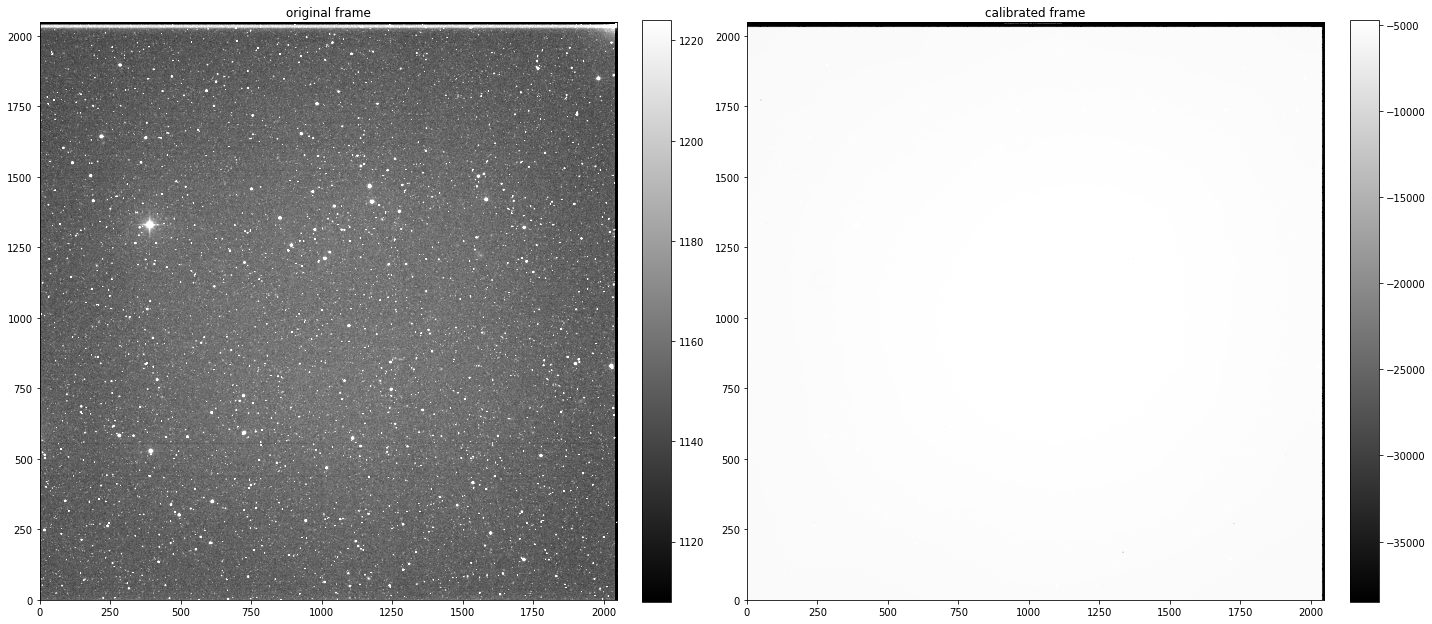

In [23]:
path = Path('/home/localadmin/2020-04-30')

science_frame = CCDData.read(path / 'PIRATE_267791_OSL_00_ds4336_CRTS_J144508_6_050514_00_B300_00_2020_04_30_02_13_19.fits', unit='adu')
bias_dir = path / 'Calibration'
dark_dir = path / 'Calibration'
flat_dir = path / 'Calibration'

calibrated_frame = calibrate_science(science_frame, flat_path=flat_dir, bias_path=bias_dir, dark_path=dark_dir)

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 40), tight_layout=True)

show_image(science_frame, cmap='gray', fig=fig, ax=axis1)
axis1.set_title('original frame')

show_image(calibrated_frame, cmap='gray', fig=fig, ax=axis2)
axis2.set_title('calibrated frame')
